<a href="https://colab.research.google.com/github/georgezefko/Anomaly-Detection-for-Sequential-Data/blob/main/VAE_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pickle5

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import torch
from torch import nn, optim
from torch import distributions
from torch.utils.data import DataLoader, TensorDataset

from torch.autograd import Variable
import os
import numpy as np
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import copy
from torch.nn.parameter import Parameter
import math
from torch.nn import functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pickle5 as pickle
import statsmodels.api
import os
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters


sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda = torch.cuda.is_available()


In [ ]:
num_hidden_dim = 128
num_enc_hidden_dim = 64
num_layers = 1
num_samples = 20
dropout_rate = 0.2
bidirectional = True
latent_size = 15
clip = True
max_grad_norm = 5
max = True

batch_size = 64
learning_rate = 0.0006796395231964973
n_epochs = 100
RANDOM_SEED = 42
green_mobility = True

## Load dataset of your choice.

In [ ]:
def heartbeat(data_train,data_test_val):
  data = np.concatenate((data_train, data_test_val), axis=0)
  df = pd.DataFrame(data)
  new_columns = list(df.columns)
  new_columns[0] = 'target'
  df.columns = new_columns
  df.target = [int(i) for i in df.target]

  normal_df = df[df.target == 1].drop(labels='target', axis=1)
  anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
  return normal_df,anomaly_df

In [ ]:
from scipy.signal import butter,filtfilt
# Filter requirements.
T = 5.0 # Sample Period
fs = 20.0 # sample rate, Hz
cutoff = 1.2 # desired cutoff frequency of the filter, Hz , slightly higher than actual 1.2 Hz
nyq = 0.5 * fs # Nyquist Frequency
order = 2 # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples
 
def butter_lowpass_filter(data, cutoff, fs, order):
  normal_cutoff = cutoff / nyq
  # Get the filter coefficients 
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = filtfilt(b, a, data)
  return y
def smoothing(Normal,Anomaly): 
  Normal_smooth = pd.DataFrame()
  for i in range(Normal.shape[0]):
    Normal_smooth = Normal_smooth.append(pd.DataFrame(butter_lowpass_filter(Normal.loc[i].values, cutoff, fs, order)).transpose())
  Normal_smooth = Normal_smooth.reset_index(drop = True) 
 
  Anomaly_smooth = pd.DataFrame()
  for i in range(Anomaly.shape[0]):
    Anomaly_smooth = Anomaly_smooth.append(pd.DataFrame(butter_lowpass_filter(Anomaly.loc[i].values, cutoff, fs, order)).transpose())
  Anomaly_smooth = Anomaly_smooth.reset_index(drop = True)
  return Normal_smooth,Anomaly_smooth

In [ ]:
if green_mobility:
  path = '/content/drive/MyDrive/AdvancedML/data/resampled_df.pickle'
  with open(path,'rb') as fh:
      data = pickle.load(fh)
  data = data[['GM.acc.xyz.z_resampled','IRI_mean']]
  data_unstacked = data.iloc[:,0].apply(list).apply(pd.Series)
  df = pd.concat([data_unstacked,data['IRI_mean']],axis=1)
  normal_df = df[df['IRI_mean'] <= 2].drop(labels='IRI_mean',axis=1).reset_index(drop = True)
  anomaly_df = df[df['IRI_mean'] > 2].drop(labels='IRI_mean',axis=1).reset_index(drop = True)
else:
  data_train = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TRAIN', delimiter=',')
  data_test_val = np.loadtxt('/content/drive/MyDrive/AdvancedML/data/ECG5000/ECG5000_TEST', delimiter=',')[:-1]
  normal_df,anomaly_df = heartbeat(data_train,data_test_val)

#for smoothing(Needs correction) it has been used only for experimentation
#normal_df,anomaly_df=smoothing(normal_df,anomaly_df)

RANDOM_SEED = 42
train_df, val_df = train_test_split(normal_df,test_size=0.33,random_state=RANDOM_SEED)
val_df, test_df = train_test_split(val_df,test_size=0.15, random_state=RANDOM_SEED)


# ## Scaling your dataset
if green_mobility:
  if max:
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_df = scaler.fit_transform(train_df)
    test_df = scaler.transform(test_df)
    val_df = scaler.transform(val_df)
    anomaly_df = scaler.fit_transform(anomaly_df)
  else:
    scaler = StandardScaler()
    train_df = scaler.fit_transform(train_df)
    test_df = scaler.transform(test_df)
    val_df = scaler.transform(val_df)
    anomaly_df = scaler.fit_transform(anomaly_df)



train_df = np.expand_dims(train_df,-1)
test_df = np.expand_dims(test_df,-1)
val_df = np.expand_dims(val_df,-1)
anomaly_df = np.expand_dims(anomaly_df,-1)

num_seq_length = train_df.shape[1]
num_features = train_df.shape[2]

train_dataset = TensorDataset(torch.from_numpy(train_df).float())
test_dataset = TensorDataset(torch.from_numpy(test_df).float())
val_dataset = TensorDataset(torch.from_numpy(val_df).float())
anomaly_dataset = TensorDataset(torch.from_numpy(anomaly_df).float())



train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=cuda,drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, pin_memory=cuda,drop_last=True)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, pin_memory=cuda, drop_last=True)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=batch_size, pin_memory=cuda,drop_last=True)



In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_features,num_seq_length,num_hidden_dim,num_layers, 
                 num_enc_hidden_dim,dropout_rate,latent_size,bidirectional):
        super(Encoder, self).__init__()
        self.num_features = num_features                                                          
        self.num_seq_length = num_seq_length                                                                                                             #BiDirectional
        self.bidirectional =  bidirectional                                                                
        self.num_hidden_dim = num_hidden_dim
        self.num_enc_hidden_dim = num_enc_hidden_dim                                                   
        self.num_layers = num_layers                                                           
        self.dropout_rate = dropout_rate                                                            
        #self.linear_dims = (self.num_enc_hidden_dim * self.num_directions, 1)           

        self.num_directions = (2 if bidirectional else 1)

        self.lstm_enc1 = nn.LSTM(
            input_size=self.num_features,                       
            hidden_size=self.num_hidden_dim,                      
            dropout=self.dropout_rate,
            num_layers=self.num_layers,                       
            batch_first=True,
            bidirectional=self.bidirectional                  
        )
        

        self.lstm_enc1.apply(self.init_weights)
        
    def init_weights(self, m):
        if type(m) == nn.LSTM:
            for name, param in m.named_parameters():
                if 'bias' in name:
                    nn.init.constant(param, 0.01)
                elif 'weight' in name:
                    nn.init.xavier_normal(param) #normal?

    def forward(self, x):
        batch_size = x.shape[0]

        x = x.reshape((batch_size, self.num_seq_length, self.num_features))

        x, (hidden, _) = self.lstm_enc1(x)
        x = hidden.reshape((batch_size, self.num_layers*self.num_directions*self.num_hidden_dim))

        return x

In [ ]:
class Latent(nn.Module):
    
    def __init__(self, num_layers,num_samples, num_hidden_dim, latent_size,bidirectional):
        super(Latent, self).__init__()

        self.bidirectional = bidirectional
        self.num_directions = (2 if bidirectional else 1)
        self.num_hidden_dim = num_hidden_dim
        self.latent_size = latent_size
        self.num_layers = num_layers
        self.num_samples = num_samples

        self.hidden_to_mean = nn.Linear(self.num_hidden_dim*self.num_directions*self.num_layers, self.latent_size)
        self.hidden_to_logvar = nn.Linear(self.num_hidden_dim*self.num_directions*self.num_layers , self.latent_size)

        nn.init.xavier_uniform_(self.hidden_to_mean.weight)
        nn.init.xavier_uniform_(self.hidden_to_logvar.weight)

    def forward(self, cell_output):
        self.latent_mean = self.hidden_to_mean(cell_output)
        self.latent_logvar = self.hidden_to_logvar(cell_output)
        mean = self.latent_mean
        log_var = self.latent_logvar
        std = torch.exp(0.5 * self.latent_logvar)
        eps = torch.randn_like(std)
        sample = eps.mul(std).add_(self.latent_mean)
        #sample = self.reparameterize(mean,log_var,epsilon_std = 1.0)
        return sample, mean, log_var
    def reparameterize(self,z_mean,z_log_var,epsilon_std = 1.0):
        batch_size = z_mean.size(0)
        epsilon = torch.FloatTensor(*[batch_size,self.num_samples, self.latent_size]).normal_(0,epsilon_std).to(device)
        z = z_mean.unsqueeze(1) + epsilon * torch.exp(0.5 * z_log_var).unsqueeze(1) 
        return torch.mean(z, dim = 1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_features,num_seq_length, num_hidden_dim, num_enc_hidden_dim,num_layers,dropout_rate,bidirectional,latent_size):
        super(Decoder, self).__init__()
        self.num_features = num_features                                                           #Features
        self.num_seq_length = num_seq_length                                                       #Sequenc                                                        #BiDirectional
        self.bidirectional =  bidirectional                                                                   #LSTM H,C -> GRU H
        self.num_hidden_dim = num_hidden_dim
        self.num_enc_hidden_dim = num_enc_hidden_dim   
        self.num_layers = num_layers                                                            #Layers
        self.dropout_rate = dropout_rate                                                            #Dropout
        self.latent_size = latent_size
        self.num_directions = (2 if bidirectional else 1)

        self.latent_to_hidden = nn.Linear(self.latent_size, self.num_enc_hidden_dim*self.num_directions*self.num_layers)

        self.lstm_dec1 = nn.LSTM(
            input_size=self.num_enc_hidden_dim*self.num_directions*self.num_layers,
            hidden_size=self.num_hidden_dim,
            num_layers=self.num_layers,
            dropout = self.dropout_rate,
            batch_first=True,
            bidirectional=self.bidirectional     
        )
        
        self.dense_layer = nn.Linear(self.num_hidden_dim*self.num_directions,self.num_features)

        self.lstm_dec1.apply(self.init_weights)
        self.dense_layer.apply(self.init_weights)

    def init_weights(self, m):
        if type(m) == nn.LSTM or type(m) == nn.Linear:
            for name, param in m.named_parameters():
                if 'bias' in name:
                    nn.init.constant(param, 0.01)
                elif 'weight' in name:
                    nn.init.xavier_normal(param) 

    def forward(self, x):
        x = self.latent_to_hidden(x)
        batch_size = x.shape[0]
        x = x.repeat(1, self.num_seq_length, self.num_features)
        x = x.reshape((batch_size, self.num_seq_length, self.num_enc_hidden_dim*self.num_directions*self.num_layers))
        x, hidden = self.lstm_dec1(x)
        x = x.reshape((batch_size, self.num_seq_length, self.num_hidden_dim*self.num_directions))
        x = self.dense_layer(x)
        return x


In [ ]:
class LSTMVAE(nn.Module):
    def __init__(self, num_features,num_seq_length, num_hidden_dim, num_enc_hidden_dim,num_layers,num_samples,dropout_rate,
                 bidirectional,latent_size):
        super(LSTMVAE, self).__init__()
        
        self.num_seq_length = num_seq_length
        self.num_features = num_features
        
        self.num_layers = num_layers
        self.num_hidden_dim = num_hidden_dim
        self.num_enc_hidden_dim = num_enc_hidden_dim
        self.bidirectional = bidirectional
        self.latent_size = latent_size
        self.num_samples = num_samples
        self.dropout_rate = dropout_rate
        
        
        self.encoder = Encoder(num_features = num_features,
                               num_seq_length = num_seq_length,
                               num_hidden_dim = num_hidden_dim,
                               num_layers = num_layers, 
                               num_enc_hidden_dim = num_enc_hidden_dim,
                               dropout_rate = dropout_rate,
                               latent_size = latent_size,
                               bidirectional = bidirectional)
        self.latent = Latent(num_layers = num_layers,
                             num_samples = num_samples,
                             num_hidden_dim = num_hidden_dim, 
                             latent_size = latent_size,
                             bidirectional = latent_size)
       
        self.decoder = Decoder(num_features = num_features,
                               num_seq_length = num_seq_length,
                               num_hidden_dim = num_hidden_dim,
                               num_layers = num_layers, 
                               num_enc_hidden_dim = num_enc_hidden_dim,
                               dropout_rate = dropout_rate,
                               bidirectional = bidirectional,
                               latent_size = latent_size)

    def forward(self, x):
      x = self.encoder(x)
      sample, z_mu, z_var = self.latent(x)
      x_decoded = self.decoder(sample)
      return x_decoded, z_mu, z_var

In [ ]:
net = LSTMVAE(num_features,num_seq_length, num_hidden_dim, num_enc_hidden_dim,num_layers,num_samples,dropout_rate,
                 bidirectional,latent_size)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


In [ ]:
print(net)

LSTMVAE(
  (encoder): Encoder(
    (lstm_enc1): LSTM(1, 128, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (latent): Latent(
    (hidden_to_mean): Linear(in_features=256, out_features=15, bias=True)
    (hidden_to_logvar): Linear(in_features=256, out_features=15, bias=True)
  )
  (decoder): Decoder(
    (latent_to_hidden): Linear(in_features=15, out_features=128, bias=True)
    (lstm_dec1): LSTM(128, 128, batch_first=True, dropout=0.2, bidirectional=True)
    (dense_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [ ]:
if cuda:
  net = net.cuda()

In [ ]:
criterion = nn.MSELoss(size_average=False)
def ELBO_loss(x, x_hat,mu, log_var):
    recon_loss = criterion(x, x_hat)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var))
    # Combining the two terms in the evidence lower bound objective (ELBO) 
    ELBO = recon_loss + kl
    return ELBO,kl


# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = ELBO_loss

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
#test model
from torch.autograd import Variable

x= next(iter(train_loader))
x = Variable(x[0])
if cuda:
    x = x.cuda()

x_hat,z_mu,z_var = net(x)

elbo,kl = loss_function(x,x_hat, z_mu,z_var)

print(x.shape)
print(x_hat.shape)
print(kl)
print(elbo)

torch.Size([64, 369, 1])
torch.Size([64, 369, 1])
tensor(1.0417, device='cuda:0', grad_fn=<MulBackward0>)
tensor(5841.4097, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
def train_model(model,train_dataset,val_dataset,num_epochs):
    history_elbo = dict(train_elbo=[], val_elbo=[])
    history_kl = dict(train_kl=[], val_kl=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    device = torch.device("cuda:0" if cuda else "cpu")
    print("Using device:", device)
    
    for epoch in range(num_epochs):
        model.train()
        # Go through  in the training dataset 
        train_elbo_losses, train_kl_losses = [], []
        for t, X in enumerate(train_dataset):
            # Index first element of array to return tensor
            X = X[0]
            # This is an alternative way of putting
            # a tensor on the GPU
            x = X.to(device)
          
            x_hat,mu,logv= net(x)
            
            elbo,kl = loss_function(x,x_hat,mu,logv)
          
            optimizer.zero_grad()
            elbo.backward()
            optimizer.step()
            if clip:
              torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = max_grad_norm)
          
            train_elbo_losses.append(elbo.item())
            train_kl_losses.append(kl.item())

      # Evaluate, do not propagate gradients
        with torch.no_grad():
            model.eval()
        valid_elbo_losses, valid_kl_losses = [], []   
        for t, X in enumerate(val_dataset):
            X = X[0]
            x = X.to(device)
            x_hat,mu,logv= net(x)
            
            elbo,kl = elbo,kl = loss_function(x,x_hat,mu,logv)
            
            valid_elbo_losses.append(elbo.item())
            valid_kl_losses.append(kl.item())
      
        train_elbo_loss = np.mean(train_elbo_losses)
        train_kl_loss = np.mean(train_kl_losses)
        valid_elbo_loss = np.mean(valid_elbo_losses)
        valid_kl_loss = np.mean(valid_kl_losses)
        if valid_elbo_loss < best_loss:
            best_loss = valid_elbo_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        print(f'Epoch {epoch}: train elbo loss {train_elbo_loss} train kl loss {train_kl_loss} val elbo loss {valid_elbo_loss} valid kl loss {valid_kl_loss}') 

      # collecting losses
        history_elbo['train_elbo'].append(train_elbo_loss)
        history_kl['train_kl'].append(train_kl_loss)
        history_elbo['val_elbo'].append(valid_elbo_loss)
        history_kl['val_kl'].append(valid_kl_loss)
    model.load_state_dict(best_model_wts)
    return model.eval(),history_elbo,history_kl

In [ ]:
model, history_elbo,history_total = train_model(net,train_loader,val_loader,n_epochs)

Using device: cuda:0
Epoch 0: train elbo loss 802.9176922607422 train kl loss 1.490815179347992 val elbo loss 421.52821132114957 valid kl loss 1.5438341753823417
Epoch 1: train elbo loss 404.5855694580078 train kl loss 1.4423932719230652 val elbo loss 397.49413917178197 valid kl loss 1.2531773589906239
Epoch 2: train elbo loss 394.3337847900391 train kl loss 1.0517009341716765 val elbo loss 392.0259849911644 valid kl loss 0.8500017154784429
Epoch 3: train elbo loss 390.865166015625 train kl loss 0.6900921928882598 val elbo loss 390.04551188151044 valid kl loss 0.5380571967079526
Epoch 4: train elbo loss 388.8023870849609 train kl loss 0.4293082642555237 val elbo loss 387.0006350562686 valid kl loss 0.3289471836317153
Epoch 5: train elbo loss 387.44043334960935 train kl loss 0.26204717278480527 val elbo loss 386.91780744280135 valid kl loss 0.20442103204273043
Epoch 6: train elbo loss 386.5220520019531 train kl loss 0.17450526416301726 val elbo loss 384.8592006138393 valid kl loss 0.152

In [ ]:
# save the model
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

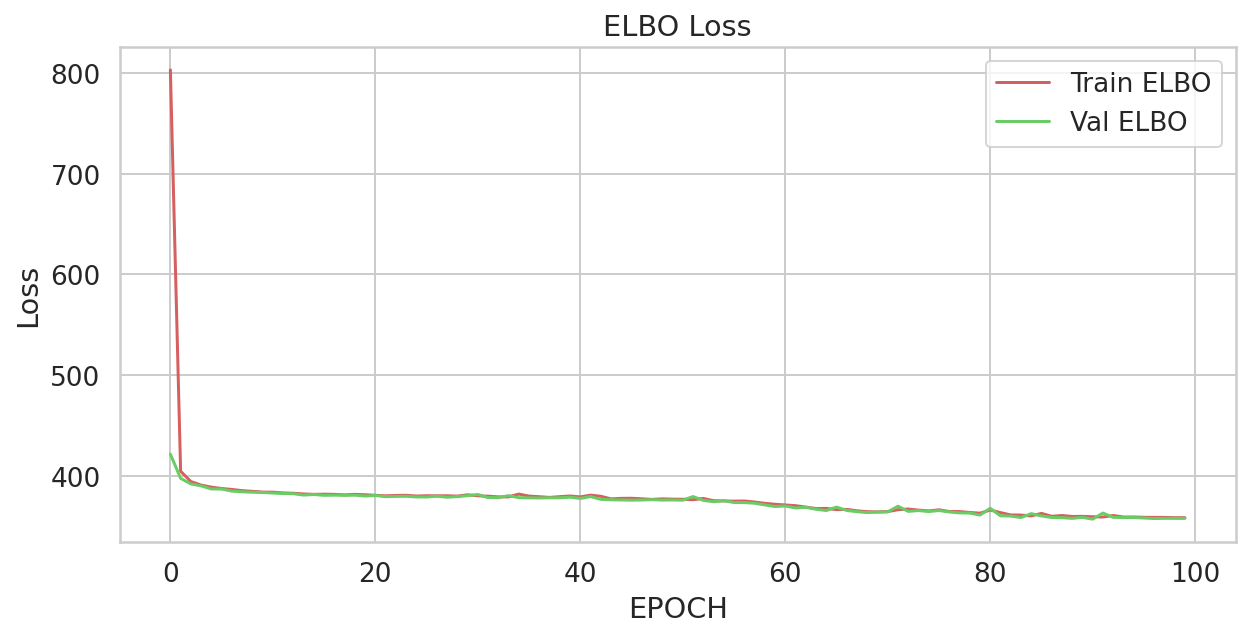

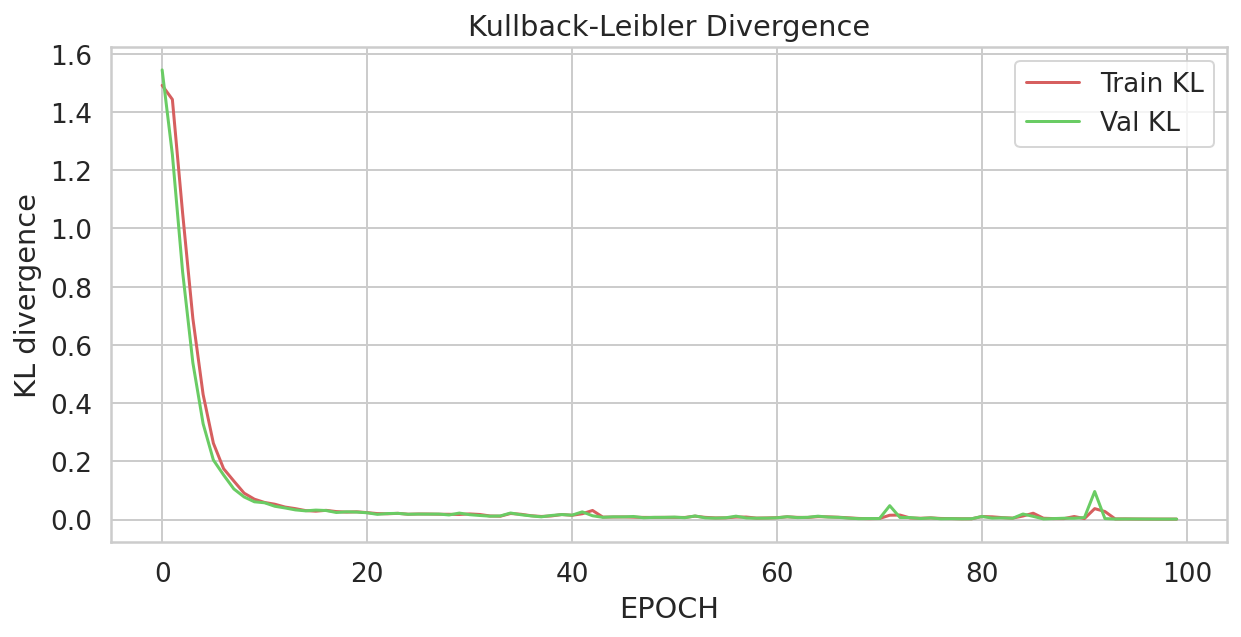

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(list(range(0,len(history_elbo['train_elbo']))), history_elbo['train_elbo'],'r')
plt.plot(list(range(0,len(history_elbo['val_elbo']))), history_elbo['val_elbo'],'g')
plt.legend(['Train ELBO','Val ELBO'])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title('ELBO Loss')
plt.show();

plt.figure(figsize=(10,10))
plt.subplot(212)
plt.plot(list(range(0,len(history_total['train_kl']))), history_total['train_kl'], 'r')
plt.plot(list(range(0,len(history_total['val_kl']))), history_total['val_kl'],'g')
plt.legend(['Train KL','Val KL'])
plt.xlabel('EPOCH')
plt.ylabel('KL divergence')
plt.title('Kullback-Leibler Divergence')

plt.show();

In [ ]:
def predict(model, dataset):
    predictions = []
    with torch.no_grad():
        model = model.eval()
    for t, X in enumerate(dataset):
        X = X[0]
        x = X.to(device)
        #x = Variable(x, requires_grad = False)
        x_hat,_,_ = model(x)
        x_hat = x_hat.detach().cpu()
        x_hat = np.squeeze(x_hat, axis=2)
        predictions.append(x_hat)
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [ ]:
def lillefor(data,predict,test=True):
  if test:
    #Lillefors test on test normal
    residual = (data - predict)
    ksstat = np.zeros(residual.shape[0])
    for i in range(residual.shape[0]):
      ksstat[i] = statsmodels.stats.diagnostic.lilliefors(residual[i,], dist='norm', pvalmethod='table')[0]
    sns.distplot(ksstat, bins=40, kde=True)
    #plt.savefig('/content/drive/MyDrive/AdvancedML/data/bigru_testnormal_rmse.png')
    plt.show()
    return ksstat
  else:
    #MSE on test normal
    sq_loss = np.mean(( data- predict)**2, axis=1)
    sns.distplot(test_sq_loss, bins=40, kde=True)
    plt.show()
    return sq_loss

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


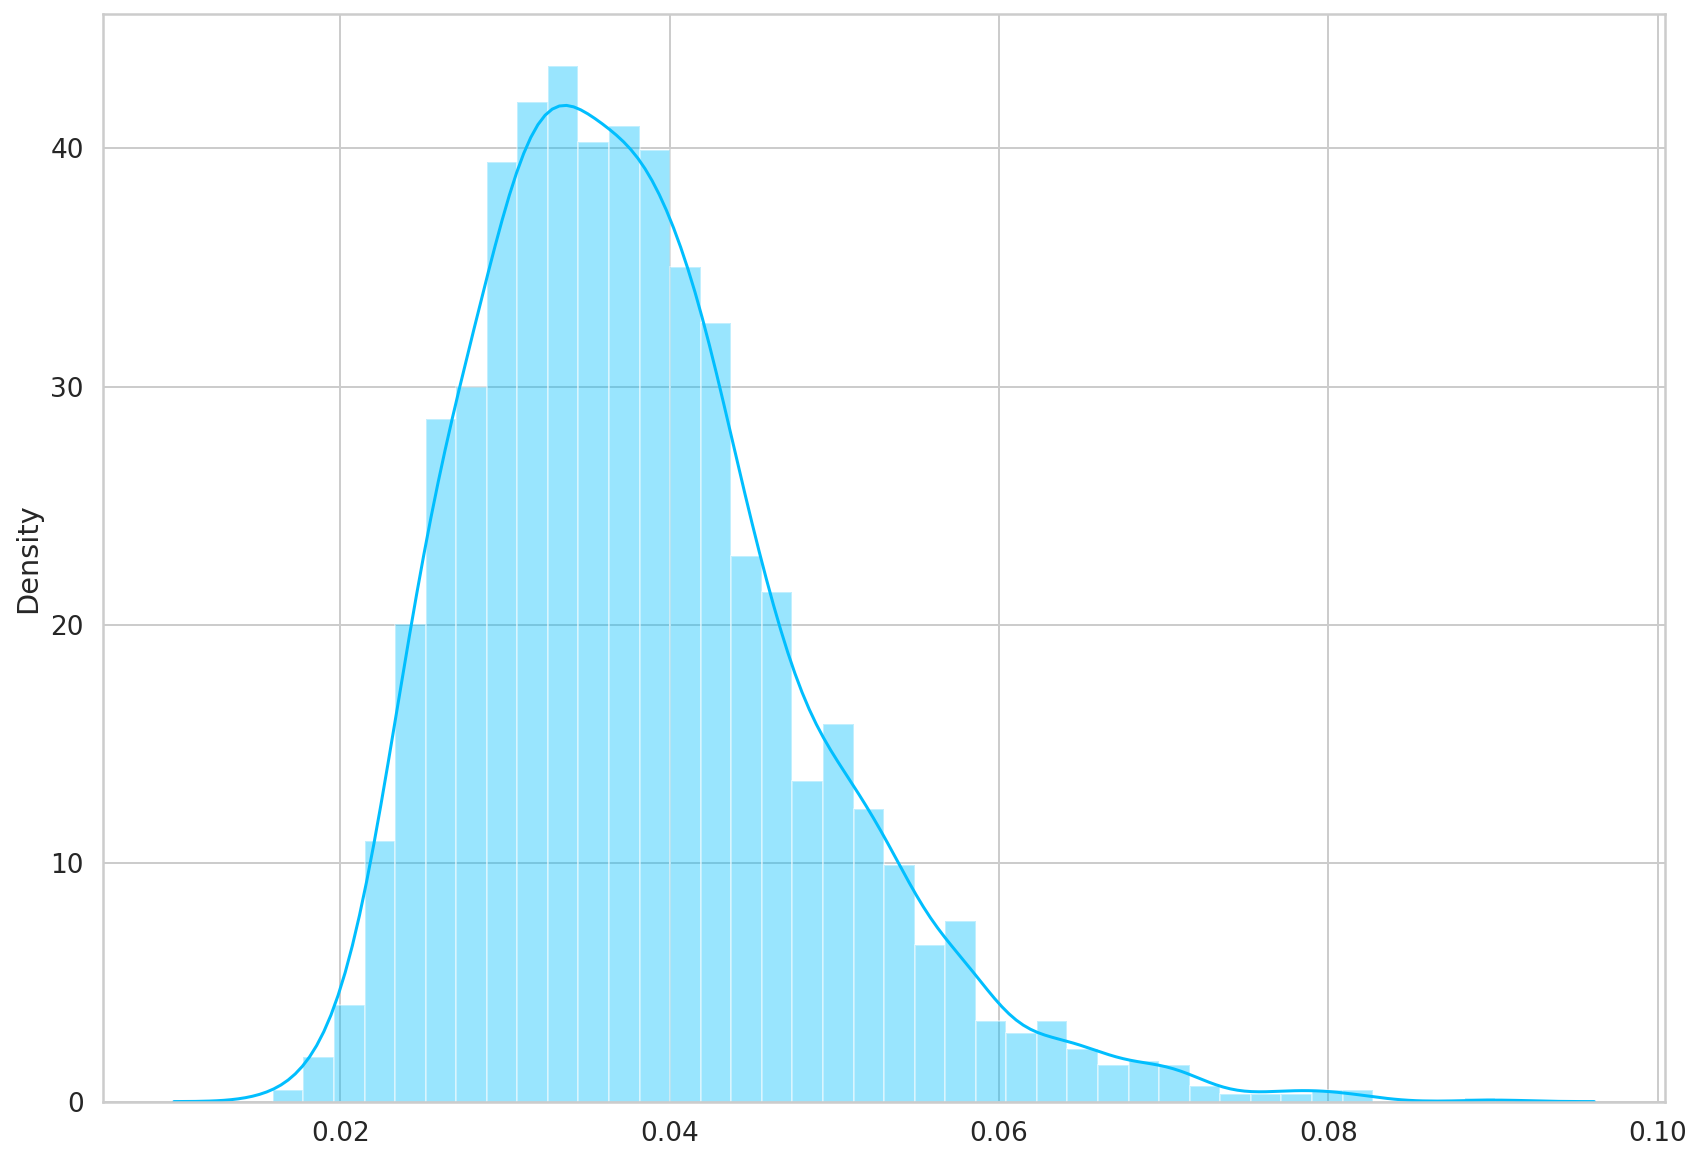

In [ ]:
predict_train = predict(model, train_loader)
train_df = train_df[:predict_train.shape[0]]
train_original = np.squeeze(train_df,axis=2)
train_recon = lillefor(train_original,predict_train)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


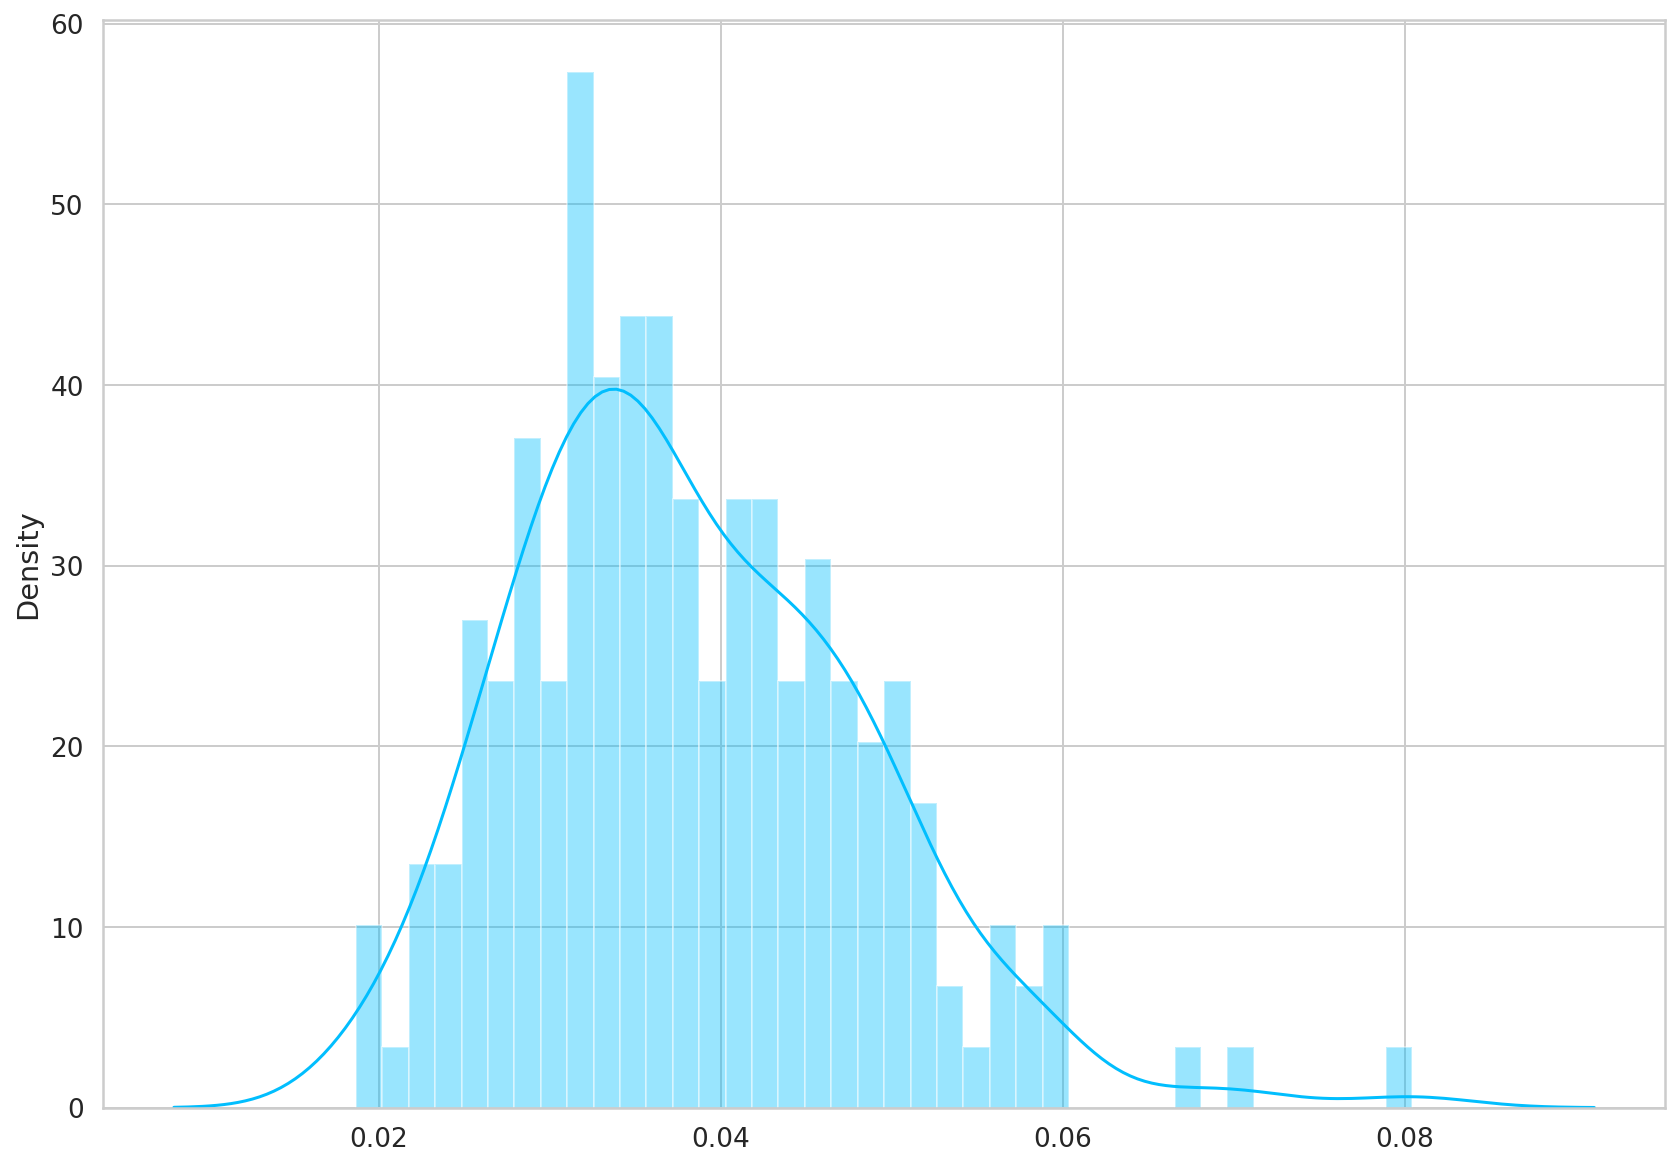

In [ ]:
predict_test = predict(model, test_loader)
test_df=test_df[:predict_test.shape[0]]
test_original = np.squeeze(test_df,axis=2)
test_recon = lillefor(test_original,predict_test)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


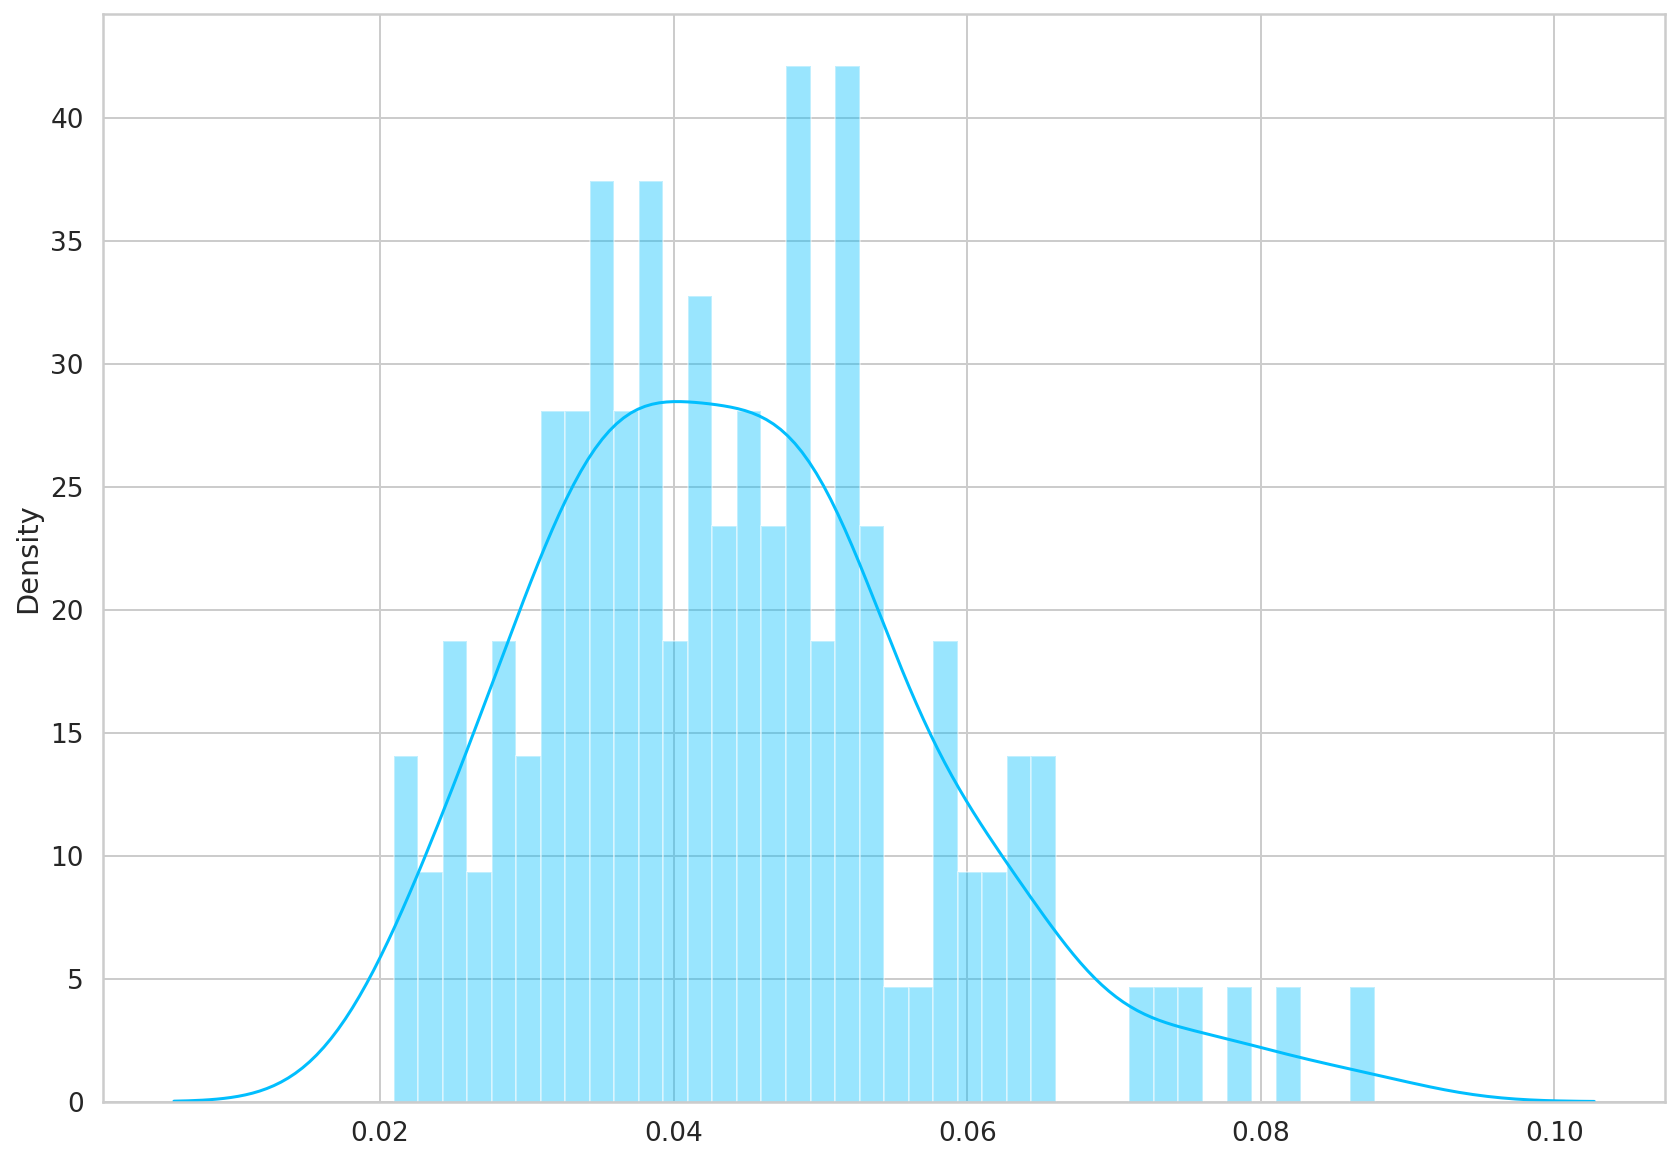

In [ ]:
predict_anomaly = predict(model, anomaly_loader)
anomaly_df = anomaly_df[:predict_anomaly.shape[0]]
anomaly_original = np.squeeze(anomaly_df)
anomaly_recon = lillefor(anomaly_original,predict_anomaly)


In [ ]:
def plot_prediction(data, reconstructed, title, ax):
  ax.plot(data,'r', label='true')
  ax.plot(reconstructed, 'b',label='reconstructed')
  ax.set_title(f'{title} (Loss: {np.around(np.sum(( data - reconstructed)**2), 2)})')
  ax.legend()

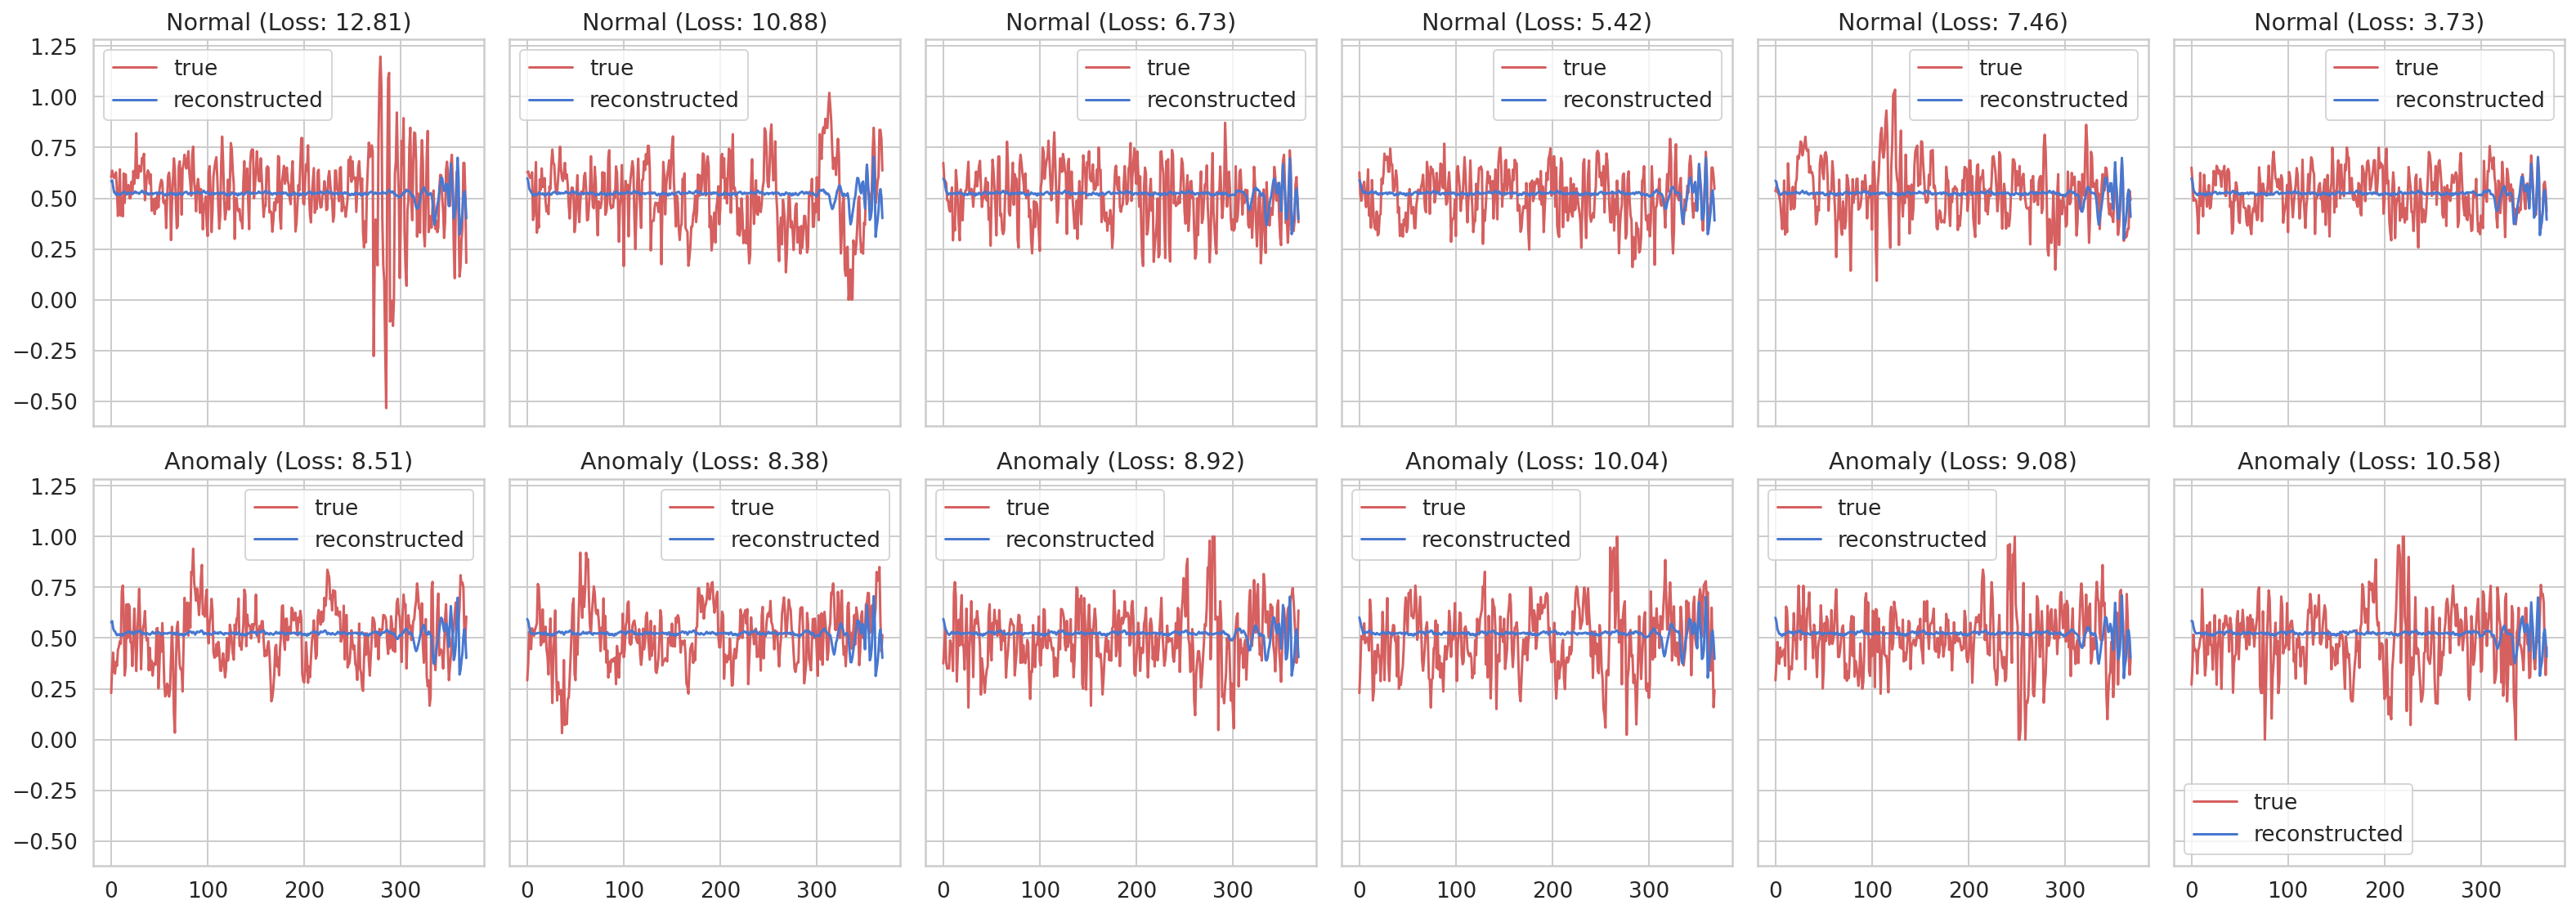

In [ ]:
fig, axs = plt.subplots(nrows=2,ncols=6,sharey=True,sharex=True,figsize=(22, 8))

for i,data in enumerate(test_original[10:16]):
    plot_prediction(data, predict_test[i], title='Normal', ax=axs[0, i])

for i, data in enumerate(anomaly_original[10:16]):
    plot_prediction(data, predict_anomaly[i], title='Anomaly', ax=axs[1, i])

fig.tight_layout();

In [ ]:
label = np.concatenate((np.zeros(len(test_recon)),np.ones(len(anomaly_recon))))
#total_losses = np.concatenate((train_sq_loss,anomaly_sq_loss),axis=0)
total_recon = np.concatenate((test_recon,anomaly_recon),axis=0)
error_df = pd.DataFrame({'Reconstruction_error': total_recon,'Label':label})
#error_df = error_df.sample(frac=1)
error_df.head(2)

,Reconstruction_error,Label
0,0.042582,0.0
1,0.028939,0.0


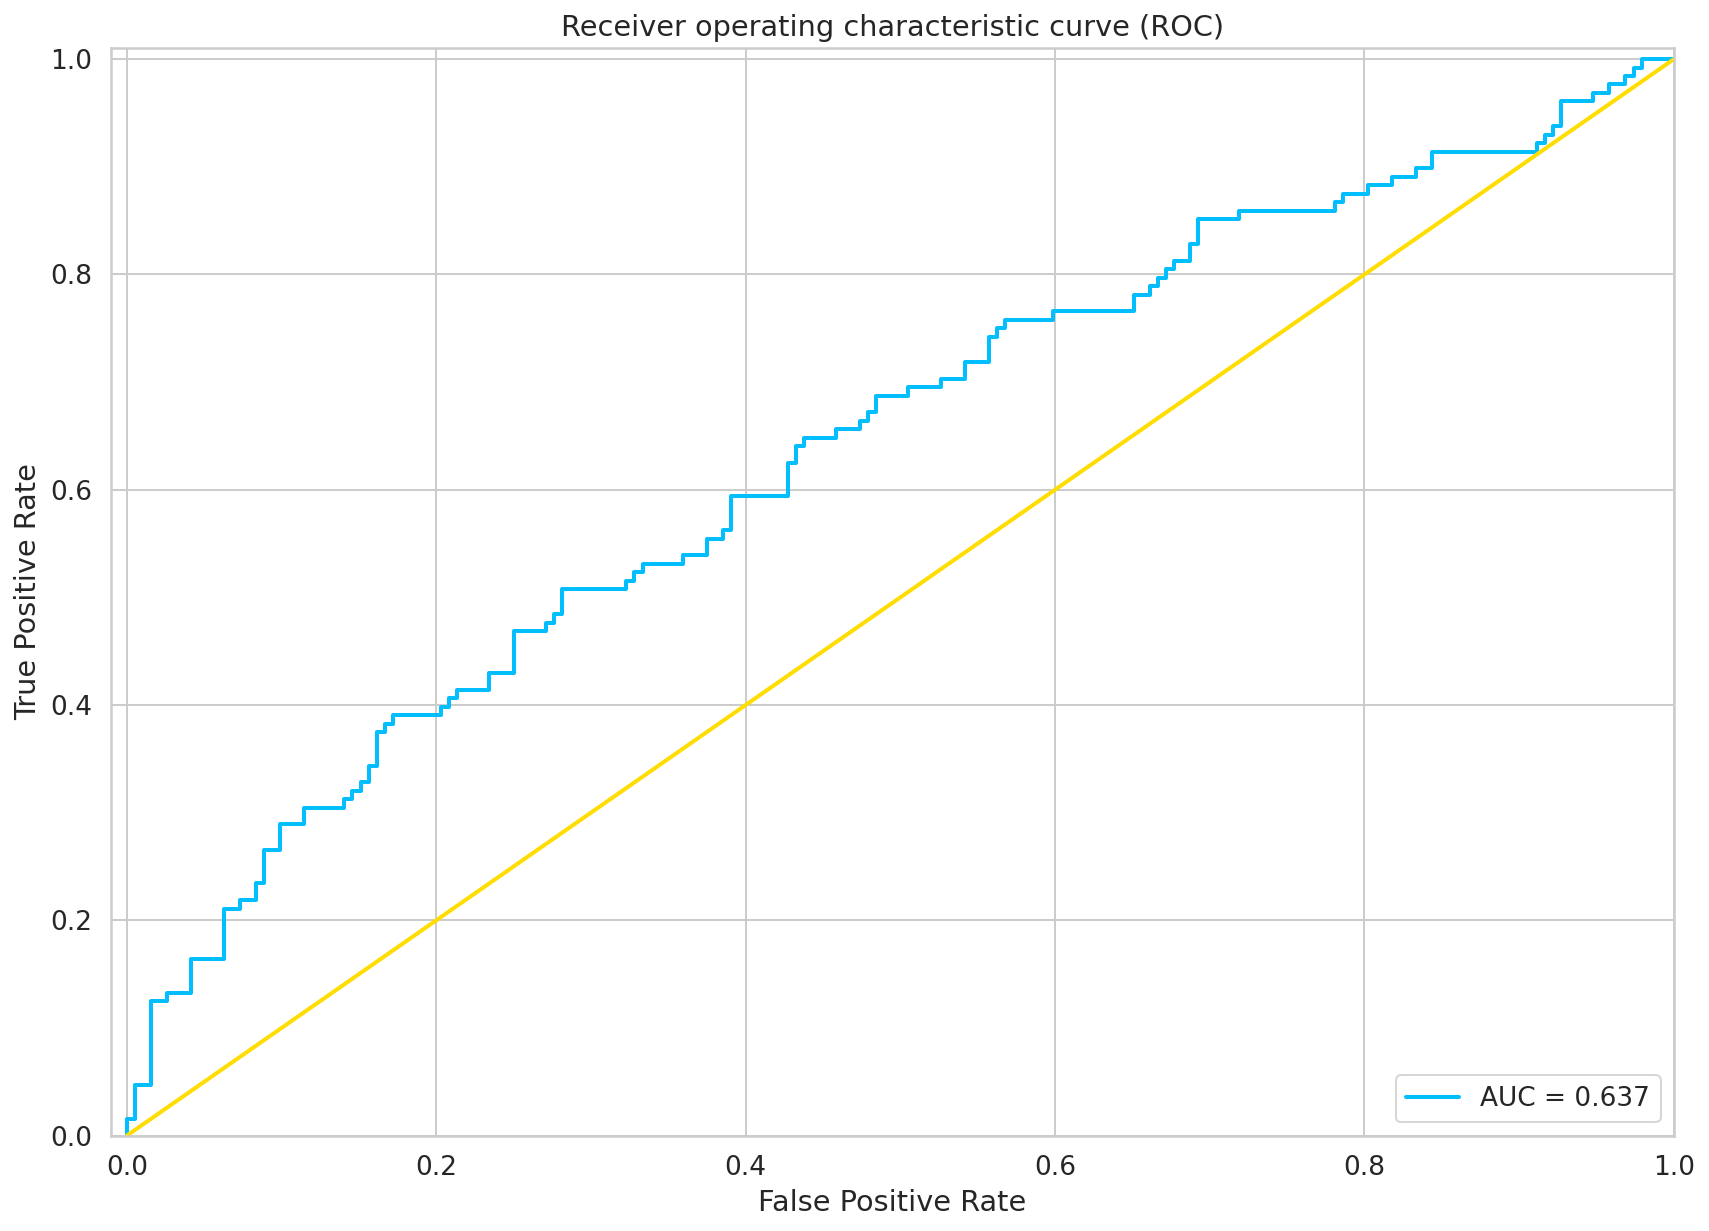

In [ ]:
#ROC-AUC 
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.Label, error_df.Reconstruction_error.values)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([1,0],[1,0], linewidth=2)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
